<h1><center> Classification of Textual Data </center></h1>
<h3><center> Alireza Seyedkanani, Ehsan Estakhrianhaghighi, Mohammadali Rastak  </h3></center>
<h3><center> March 7 2022 </h3></center>
<center> This code is for the first dataset, i.e. 20 news groups dataset. For the second dataset please refer to the corresponding code. </</center>

# Preamble

We import the required packages.

In [ ]:
# importing the necessary packages
import numpy as np
from scipy.sparse import csr_matrix
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from google.colab import files
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# Task 1: Acquire, preprocess, and analyze the data

Herein, we import the data from sklearn datasets. The train and test sets have already been specified. We first get to know the dataset by cheking the sizes of the train and target sets, the number of class labels, target names, class distributions, etc.

## Importing data

In [ ]:
from sklearn.datasets import fetch_20newsgroups as newsgroup

corpus_train = newsgroup(subset='train', remove=(['headers', 'footers', 'quotes']))
corpus_test = newsgroup(subset='test', remove=(['headers', 'footers', 'quotes']))

# In case of selecting specific categories
#categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']
#corpus_train = newsgroup(subset='train', categories=categories, remove=(['headers', 'footers', 'quotes']))
#corpus_test = newsgroup(subset='test', categories=categories, remove=(['headers', 'footers', 'quotes']))

print('Number of the documents in the train dataset = ', len(corpus_train.data))
print('Number of the documents in the test dataset = ', len(corpus_test.data))
print('Number of class labels = ', len(corpus_train.target_names))
print('\nClass labels:')
list(corpus_train.target_names)

Number of the documents in the train dataset =  11314
Number of the documents in the test dataset =  7532
Number of class labels =  20

Class labels:


['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

As an example, we print a document and its assigned label.

In [ ]:
print(corpus_train.data[1],'\n')
print('Assigned class label:', corpus_train.target_names[corpus_train.target[1]],'\n')

A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

I will be summarizing in the next two days, so please add to the network
knowledge base if you have done the clock upgrade and haven't answered this
poll. Thanks. 

Assigned class label: comp.sys.mac.hardware 



The class distribution is plotted below. The class distribution is almost uniform in the train set.

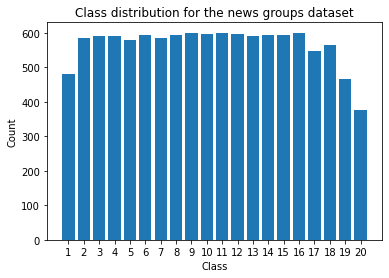

In [ ]:
unique, counts = np.unique(corpus_train.target, return_counts=True)
x_axis = np.arange(len(unique))
plt.bar(unique, counts)
plt.title('Class distribution for the news groups dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(x_axis, unique+1)
plt.show()

## Feature extraction

In order to extract features and turn the text content into numerical features, we utilize CountVectorizer to find out the counts of the identified distinct words in the documents. For this, we define a function to remove numbers and underscores from the text. The default tokenizer ignores special characters. we also use the default stop word. Subsequently, using TfidfTransformer we normalize the features by transforming the corresponding count vectors to frequencies. Our experiments show that this refinement results in better accuracies for our models.

We can specify the minimum and maximum document frequencies (ignoring terms that have frequencies lower and higher than the given thresholds) for further refinements. Changing these values results in different number of features. Different word n-grams also results in different number of features. In the upcomming sections, we study the effect of these parameters on the performance of the model.

In [ ]:
# function for removing digits

def remove_digits(X):
  corpus = X.copy()
  for index, s in enumerate(corpus):
    s = ''.join([i for i in s if not i.isdigit()])
    corpus[index] = s
  return corpus

# function for removing underscores

def remove_underscore(X):
  corpus = X.copy()
  for index, s in enumerate(corpus):
    corpus[index] = s.replace("_", " ")
  return corpus

corpus_train.data = remove_underscore(remove_digits(corpus_train.data))
corpus_test.data =remove_underscore(remove_digits(corpus_test.data))

# count features
count_vect = CountVectorizer(lowercase=True,
                             stop_words='english',
                             min_df=2,
                             ngram_range=(1,3))

X_train_counts = count_vect.fit_transform(corpus_train.data)
X_test_counts = count_vect.transform(corpus_test.data)
feature_names = count_vect.get_feature_names_out()

print('Number of features = ', X_train_counts.shape[1])
#print(feature_names[0:1000])

# transforming word counts to frequencies
tfidf_t = TfidfTransformer(use_idf=True,
                         norm='l2')

X_train_freqs = tfidf_t.fit_transform(X_train_counts)
X_test_freqs = tfidf_t.transform(X_test_counts)

# multi-class
y_train = corpus_train.target
y_test = corpus_test.target

# One may use decomposition tools to reduce the number of features.
# However, using this method in the current project, e.g. to reduce the number
# of features to 100, results in reduced accuracies.

#from sklearn.decomposition import TruncatedSVD
#svd = TruncatedSVD(n_components=100)
#X_train = svd.fit_transform(X_train)

Number of features =  187682


For example, the word with the highest frequency can be found as follows:

In [ ]:
from numpy import unravel_index
print(unravel_index(np.argmax(X_train_freqs), X_train_freqs.shape))
print(X_train_freqs[unravel_index(np.argmax(X_train_freqs), X_train_freqs.shape)])
print(feature_names[unravel_index(np.argmax(X_train_freqs), X_train_freqs.shape)[1]])

(8986, 3115)
1.0
agree


# Task 2: Implement Naive Bayes and k-fold cross validation

Here we implement Multinomial Naive Bayes. We harness operations using sparse matrix (csr_matrix) to speed up the calculations and to prevent RAM from being used up.

## Naive Bayes (Multinomial, count/frequency features)

In [ ]:
def logsumexp(Z):
  Zmax = np.max(Z,axis=0)[None,:]
  log_sum_exp = Zmax + np.log(np.sum(np.exp(Z - Zmax), axis=0))
  return log_sum_exp

class MultinomialNaiveBayes:
  def __init__(self, alpha=1):
    self.alpha = alpha
    return

  def fit(self, x, y):
    N, D = x.shape
    C = np.max(y) + 1
    Nc = np.zeros(C)
    theta = np.zeros((C, D))

    for c in range(C):
      x_c = x[y == c]
      Nc[c] = x_c.shape[0]
      theta[c,:] = (x_c.sum(0) + self.alpha)/(x_c.sum(0).sum(1) + self.alpha*D)

    self.pi = (Nc+1)/(N+C)
    self.theta = theta
    self.C = C
    return self.theta

  def predict(self, xt):
    Nt, D = xt.shape
    log_prior = np.log(self.pi)[:, None]
    log_likelihood = (csr_matrix(np.log(self.theta)) * xt.transpose()).toarray()
    log_posterior = log_prior + log_likelihood
    posterior = np.exp(log_posterior - logsumexp(log_posterior))
    prediction = np.argmax(posterior.T, 1)
    return prediction

## Naive Bayes (Gaussian, continious features)

In [ ]:
def logsumexp(Z):
  Zmax = np.max(Z,axis=0)[None,:]
  log_sum_exp = Zmax + np.log(np.sum(np.exp(Z - Zmax), axis=0))
  return log_sum_exp

class GaussianNaiveBayes:
  def __init__(self):
    return

  def fit(self, x, y):
    N, D = x.shape
    C = np.max(y) + 1
    mu, sigma = np.zeros((C,D)), np.zeros((C,D))
    Nc = np.zeros(C)

    for c in range(C):
      x_c = x[y == c]
      Nc[c] = x_c.shape[0]
      mu[c,:] = np.mean(x_c,0)
      #sigma[c,:] = np.std(x_c.toarray(), 0)
      # The code below is faster since it does not convert the sparse matrix to array
      sigma[c,:] = np.squeeze(np.asarray(np.power(np.mean(csr_matrix.power(x_c,2), 0) - np.power((np.mean(x_c,0)),2),0.5)))
      # Since some of the stds might be zero, we use std + eps to avoid future problems
      sigma[c, (sigma[c,:] == 0)] = np.random.rand(1)*0.00001

    self.mu = mu
    self.sigma = sigma
    self.pi = (Nc+1)/(N+C)
    self.C = C
    return self

  def predict(self, xt):
    Nt, D = xt.shape
    log_likelihood = np.zeros((self.C,Nt))
    log_prior = np.log(self.pi)[:, None]
    # to avoid converting csr_matrix to array and filling up the RAM, we use the following calculations:
    for c in range(self.C):
      for i in range(Nt):
        sum1 = 0.5*np.log(2*np.pi)*D
        sum2 = np.sum(np.log(self.sigma[c,:]))
        sum3 = np.sum(np.delete(self.mu[c,:], xt[i,:].indices)**2/(2*(np.delete(self.sigma[c,:], xt[i,:].indices)**2)))
        sum4 = np.sum((xt[i,:].data - self.mu[c, xt[i,:].indices])**2/(2*(self.sigma[c, xt[i,:].indices])**2))
        log_likelihood[c,i] = - sum1 - sum2 - sum3 - sum4
    log_posterior = log_prior + log_likelihood
    posterior = np.exp(log_posterior - logsumexp(log_posterior))
    return posterior.T

## Accuracy evaluation

In [ ]:
def evaluate_acc(y, y_pred):
  accuracy = np.mean(y_pred == y)
  return accuracy

## Cross validation

In [ ]:
def cross_validation_split(x_train, y_train, k_folds=5, shuffle=False):
    n = x_train.shape[0]
    n_val = n // k_folds
    if shuffle:
      inds = np.random.permutation(n)
    else:
      inds = range(n)
    for f in range(k_folds):
        tr_inds = []
        val_inds = list(inds[f * n_val:(f+1)*n_val])
        if f > 0:
            tr_inds = list(inds[:f*n_val])
        if f < k_folds - 1:
            tr_inds = tr_inds + list(inds[(f+1)*n_val: n])
        yield x_train[tr_inds], x_train[val_inds], y_train[tr_inds], y_train[val_inds]

In [ ]:
def kfoldCV(model, x_train, y_train, k_folds=5, shuffle=False):

  acc_val = np.zeros(k_folds)

  for f, (x_tr, x_val, y_tr, y_val) in enumerate(cross_validation_split(x_train, y_train, k_folds, shuffle)):
    model.fit(x_tr, y_tr)
    y_pred = model.predict(x_val)
    acc_val[f] = evaluate_acc(y_val, y_pred)

  return np.mean(acc_val), np.std(acc_val)

# Task 3: Run experiments

## Hyper-parameter tuning

In this section we use 5-fold cross validation for hyper-parametr tuning for both models.

### Naive Bayes

By considering the smoothing parameter $α=1$ for multinomila Naive Bayes model, we can select the best parameters for our vectorizer. We use TdidfVectorizer and evaluate the mean cross-validated score for different mid_df and ngram_range parameters.

In [ ]:
min_df_list = [1, 2, 3]
acc_val_mean = np.zeros(len(min_df_list))
for i, min_df in enumerate(min_df_list):
  tfidf = TfidfVectorizer(lowercase=True,
                          use_idf=True,
                          stop_words='english',
                          min_df=min_df,
                          ngram_range=(1,1))

  X_train = tfidf.fit_transform(corpus_train.data)

  model = MultinomialNaiveBayes(alpha=1)
  acc_val_mean[i], _ = kfoldCV(model, X_train, y_train, k_folds=5, shuffle=False)

  print("min_df = %r: mean CV score = %r" % (min_df, acc_val_mean[i]))

min_df = 1: mean CV score = 0.7137046861184793
min_df = 2: mean CV score = 0.7201591511936339
min_df = 3: mean CV score = 0.7200707338638374


In [ ]:
ngram_range_list = [(1,1), (1,2), (1,3), (2,3), (3,3)]
acc_val_mean = np.zeros(len(ngram_range_list))
for i, ngram_range in enumerate(ngram_range_list):
  tfidf = TfidfVectorizer(lowercase=True,
                          use_idf=True,
                          stop_words='english',
                          min_df=2,
                          ngram_range=ngram_range)

  X_train = tfidf.fit_transform(corpus_train.data)

  model = MultinomialNaiveBayes(alpha=1)
  acc_val_mean[i], _ = kfoldCV(model, X_train, y_train, k_folds=5, shuffle=False)

  print("ngram_range = %r: mean CV score = %r" % (ngram_range, acc_val_mean[i]))

ngram_range = (1, 1): mean CV score = 0.7201591511936339
ngram_range = (1, 2): mean CV score = 0.7254641909814323
ngram_range = (1, 3): mean CV score = 0.7270557029177718
ngram_range = (2, 3): mean CV score = 0.6100795755968169
ngram_range = (3, 3): mean CV score = 0.3750663129973475


In [ ]:
tfidf = TfidfVectorizer(lowercase=True,
                          use_idf=True,
                          stop_words='english',
                          min_df=2,
                          ngram_range=(1,3))

X_train_freqs = tfidf.fit_transform(corpus_train.data)
X_test_freqs = tfidf.transform(corpus_test.data)

print('Number of features = ', X_train_freqs.shape[1])

Number of features =  187682


In [ ]:
alpha_list = np.logspace(-3, 1.0, num=50)
k_folds = 5

acc_val_mean, acc_val_std = np.zeros(len(alpha_list)), np.zeros(len(alpha_list))
acc_train, acc_test = np.zeros(len(alpha_list)), np.zeros(len(alpha_list))

for i, alpha in enumerate(alpha_list):
    model = MultinomialNaiveBayes(alpha=alpha)
    acc_val_mean[i], acc_val_std[i] = kfoldCV(model, X_train_freqs, y_train, k_folds, shuffle=False)

    model.fit(X_train_freqs, y_train)
    y_pred_test = model.predict(X_test_freqs)
    acc_test[i] = evaluate_acc(y_test, y_pred_test)
    y_pred_train = model.predict(X_train_freqs)
    acc_train[i] = evaluate_acc(y_train, y_pred_train)

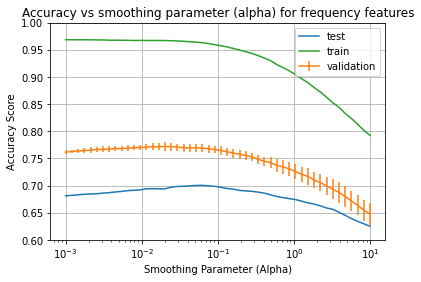

The best alpha based on the validation accuracy is 0.02.
The validation accuracy with the best alpha is 77.2%.
The test accuracy with the best alpha is 69.4%.


In [ ]:
plt.xscale('log')
plt.plot(alpha_list, acc_test,  label='test')
plt.errorbar(alpha_list, acc_val_mean, acc_val_std, label='validation')
plt.plot(alpha_list, acc_train,  label='train')
plt.legend(loc='upper right')
plt.xlabel('Smoothing Parameter (Alpha)')
plt.ylabel('Accuracy Score')
plt.ylim((0.6, 1))
plt.grid(b=True)
plt.title('Accuracy vs smoothing parameter (alpha) for frequency features')
#plt.savefig('MNB_acc.pdf', format='pdf', bbox_inches='tight')
#files.download('MNB_acc.pdf')
plt.show()

best_alpha = alpha_list[np.argmax(acc_val_mean)]
print(f'The best alpha based on the validation accuracy is {best_alpha:.2f}.')

model = MultinomialNaiveBayes(alpha=best_alpha)
model.fit(X_train_freqs, y_train)
y_pred = model.predict(X_test_freqs)
print(f'The validation accuracy with the best alpha is {np.max(acc_val_mean)*100:.1f}%.')
print(f'The test accuracy with the best alpha is {evaluate_acc(y_test, y_pred)*100:.1f}%.')

Using counts of the words instead of their frequencies generally results in worse accuracies:

In [ ]:
count_vect = CountVectorizer(lowercase=True,
                             stop_words='english',
                             min_df=2,
                             ngram_range=(1,3))

X_train_counts = count_vect.fit_transform(corpus_train.data)
X_test_counts = count_vect.transform(corpus_test.data)

print('Number of features = ', X_train_counts.shape[1])

Number of features =  187682


In [ ]:
alpha_list = np.logspace(-3, 1.0, num=50)
k_folds = 5

acc_val_mean, acc_val_std = np.zeros(len(alpha_list)), np.zeros(len(alpha_list))
acc_train, acc_test = np.zeros(len(alpha_list)), np.zeros(len(alpha_list))

for i, alpha in enumerate(alpha_list):
    model = MultinomialNaiveBayes(alpha=alpha)
    acc_val_mean[i], acc_val_std[i] = kfoldCV(model, X_train_counts, y_train, k_folds, shuffle=False)

    model.fit(X_train_counts, y_train)
    y_pred_test = model.predict(X_test_counts)
    acc_test[i] = evaluate_acc(y_test, y_pred_test)
    y_pred_train = model.predict(X_train_counts)
    acc_train[i] = evaluate_acc(y_train, y_pred_train)

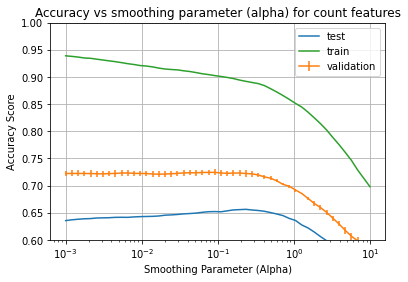

The best alpha based on the validation accuracy is 0.091.
The validation accuracy with the best alpha is 72.4%.
The test accuracy with the best alpha is 69.9%.


In [ ]:
plt.xscale('log')
plt.plot(alpha_list, acc_test,  label='test')
plt.errorbar(alpha_list, acc_val_mean, acc_val_std, label='validation')
plt.plot(alpha_list, acc_train,  label='train')
plt.legend(loc='upper right')
plt.xlabel('Smoothing Parameter (Alpha)')
plt.ylabel('Accuracy Score')
plt.ylim((0.6, 1))
plt.grid(b=True)
plt.title('Accuracy vs smoothing parameter (alpha) for count features')
#plt.savefig('MNB_acc.pdf', format='pdf', bbox_inches='tight')
#files.download('MNB_acc.pdf')
plt.show()

best_alpha = alpha_list[np.argmax(acc_val_mean)]
print(f'The best alpha based on the validation accuracy is {best_alpha:.3f}.')

model = MultinomialNaiveBayes(alpha=best_alpha)
model.fit(X_train_freqs, y_train)
y_pred = model.predict(X_test_freqs)
print(f'The validation accuracy with the best alpha is {np.max(acc_val_mean)*100:.1f}%.')
print(f'The test accuracy with the best alpha is {evaluate_acc(y_test, y_pred)*100:.1f}%.')

### Logestic Regression

By considering the parameter $C=1$, which shows the inverse of the regularization strength for Logestic Regression model, we select the best parameters for our vectorizer. We use TdidfVectorizer and evaluate the mean cross-validated score for different mid_df and ngram_range parameters.

In [ ]:
min_df_list = [1, 2, 3]
acc_val_mean = np.zeros(len(min_df_list))
for i, min_df in enumerate(min_df_list):
  tfidf = TfidfVectorizer(lowercase=True,
                          use_idf=True,
                          stop_words='english',
                          min_df=min_df,
                          ngram_range=(1,1))

  X_train = tfidf.fit_transform(corpus_train.data)

  model = LogisticRegression(multi_class='multinomial', max_iter=300, C=1, solver='lbfgs')
  acc_val_mean[i], _ = kfoldCV(model, X_train, y_train, k_folds=5, shuffle=False)

  print("min_df = %r: mean CV score = %r" % (min_df, acc_val_mean[i]))

min_df = 1: mean CV score = 0.737577365163572
min_df = 2: mean CV score = 0.7386383731211318
min_df = 3: mean CV score = 0.7374889478337754


In [ ]:
ngram_range_list = [(1,1), (1,2), (1,3), (2,3), (3,3)]
acc_val_mean = np.zeros(len(ngram_range_list))
for i, ngram_range in enumerate(ngram_range_list):
  tfidf = TfidfVectorizer(lowercase=True,
                          use_idf=True,
                          stop_words='english',
                          min_df=2,
                          ngram_range=ngram_range)

  X_train = tfidf.fit_transform(remove_underscore(remove_digits(corpus_train.data)))

  model = LogisticRegression(multi_class='multinomial', max_iter=300, C=1, solver='lbfgs')
  acc_val_mean[i], _ = kfoldCV(model, X_train, y_train, k_folds=5, shuffle=False)

  print("ngram_range = %r: mean CV score = %r" % (ngram_range, acc_val_mean[i]))

ngram_range = (1, 1): mean CV score = 0.7386383731211318
ngram_range = (1, 2): mean CV score = 0.7442970822281167
ngram_range = (1, 3): mean CV score = 0.7469496021220159
ngram_range = (2, 3): mean CV score = 0.6001768346595934
ngram_range = (3, 3): mean CV score = 0.379840848806366


In [ ]:
tfidf = TfidfVectorizer(lowercase=True,
                          use_idf=True,
                          stop_words='english',
                          min_df=2,
                          ngram_range=(1,3))

X_train_freqs = tfidf.fit_transform(remove_underscore(remove_digits(corpus_train.data)))
X_test_freqs = tfidf.transform(remove_underscore(remove_digits(corpus_test.data)))

print('Number of features = ', X_train_freqs.shape[1])

Number of features =  187682


In [ ]:
C_list = np.logspace(-3, 1.0, num=5)
k_folds = 5

acc_val_mean, acc_val_std = np.zeros(len(C_list)), np.zeros(len(C_list))
acc_train, acc_test = np.zeros(len(C_list)), np.zeros(len(C_list))

for i, C in enumerate(C_list):
    model = LogisticRegression(multi_class='multinomial', max_iter=300, C=C, solver='lbfgs')
    acc_val_mean[i], acc_val_std[i] = kfoldCV(model, X_train_freqs, y_train, k_folds, shuffle=False)

    model.fit(X_train_freqs, y_train)
    y_pred_test = model.predict(X_test_freqs)
    acc_test[i] = evaluate_acc(y_test, y_pred_test)
    y_pred_train = model.predict(X_train_freqs)
    acc_train[i] = evaluate_acc(y_train, y_pred_train)

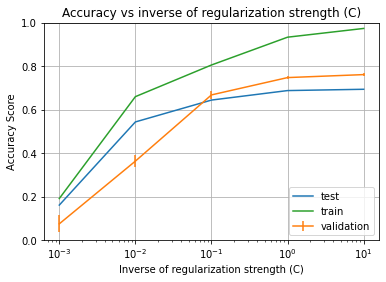

The best C based on the validation accuracy is: 10.00.
The validation accuracy with the best C is 76.1%.
The test accuracy with the best C is 69.3%.


In [ ]:
plt.xscale('log')
plt.plot(C_list, acc_test,  label='test')
plt.errorbar(C_list, acc_val_mean, acc_val_std, label='validation')
plt.plot(C_list, acc_train,  label='train')
plt.legend(loc='lower right')
plt.xlabel('Inverse of regularization strength (C)')
plt.ylabel('Accuracy Score')
plt.ylim((0, 1))
plt.grid(b=True)
plt.title('Accuracy vs inverse of regularization strength (C)')
#plt.savefig('LR_acc.pdf', format='pdf', bbox_inches='tight')
#files.download('LR_acc.pdf')
plt.show()

best_C = C_list[np.argmax(acc_val_mean)]
print(f'The best C based on the validation accuracy is: {best_C:.2f}.')

model = LogisticRegression(multi_class='multinomial', max_iter=300, C=best_C, solver='lbfgs')
model.fit(X_train_freqs, y_train)
y_pred = model.predict(X_test_freqs)
print(f'The validation accuracy with the best C is {np.max(acc_val_mean)*100:.1f}%.')
print(f'The test accuracy with the best C is {evaluate_acc(y_test, y_pred)*100:.1f}%.')

# for a classification report, uncomment the lines below
#print(classification_report(y_test, y_pred, target_names=corpus_test.target_names))
#print(confusion_matrix(y_test, yh)[3:8,3:8])

We change stopping tolerance as another hyper-parameter for logetsic regression and investigate its effect on the validation accuracy.

In [ ]:
tol_list = [1e-5, 1e-1, 1]
k_folds = 5

acc_val_mean = np.zeros(len(tol_list))

for i, tol in enumerate(tol_list):
    model = LogisticRegression(multi_class='multinomial', max_iter=500, C=1, tol=tol, solver='lbfgs')
    acc_val_mean[i], _ = kfoldCV(model, X_train_freqs, y_train, k_folds, shuffle=False)

    print("tolerance = %r: mean CV score = %r" % (tol, acc_val_mean[i]))

tolerance = 1e-05: mean CV score = 0.7469496021220159
tolerance = 0.1: mean CV score = 0.7468611847922193
tolerance = 1: mean CV score = 0.7473032714412026


## Dependency on the size of the train set

In this section we evaluate the dependency of the two models on the size of the train dataset.

In [ ]:
tfidf = TfidfVectorizer(lowercase=True,
                          use_idf=True,
                          stop_words='english',
                          min_df=2,
                          ngram_range=(1,3))

tfidf.fit(remove_underscore(remove_digits(corpus_train.data)))
X_test = tfidf.transform(remove_underscore(remove_digits(corpus_test.data)))
y_test = corpus_test.target

n = len(corpus_train.data)
size = np.array([0.2, 0.4, 0.6, 0.8, 1])
accuracy_MNB = np.zeros(len(size))
accuracy_LR = np.zeros(len(size))
for i in range(len(size)):
  inds = range(n)[:int(size[i]*n)]
  # to shuffle the data uncomment the line below:
  inds = np.random.permutation(n)[:int(size[i]*n)]

  # If we want to have same feature sizes in every size:
  #X_train = tfidf.transform(remove_underscore(remove_digits([corpus_train.data[index] for index in inds])))
  #y_train = corpus_train.target[inds]

  # If we want to have different feature sizes in every size:
  X_train = tfidf.fit_transform(remove_underscore(remove_digits([corpus_train.data[index] for index in inds])))
  y_train = corpus_train.target[inds]
  #X_test = tfidf.transform(remove_underscore(remove_digits(corpus_test.data)))
  #y_test = corpus_test.target

  model = MultinomialNaiveBayes(alpha=0.02)
  #model.fit(X_train, y_train)
  #y_pred = model.predict(X_test)
  accuracy_MNB[i], _ = kfoldCV(model, X_train, y_train, k_folds=5, shuffle=False)

  model = LogisticRegression(multi_class='multinomial', max_iter=300, C=10, solver='lbfgs')
  #model.fit(X_train, y_train)
  #y_pred = model.predict(X_test)
  accuracy_LR[i], _ = kfoldCV(model, X_train, y_train, k_folds=5, shuffle=False)

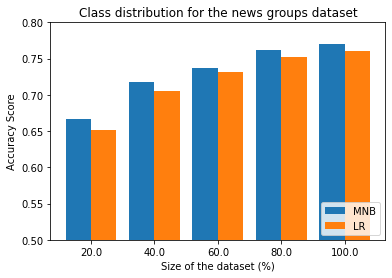

In [ ]:
x_axis = np.arange(len(size))
width = 0.4

plt.bar(x_axis - width/2, accuracy_MNB, width, label='MNB')
plt.bar(x_axis + width/2, accuracy_LR, width, label='LR')
plt.title('Class distribution for the news groups dataset')
plt.xlabel('Size of the dataset (%)')
plt.legend(loc='lower right')
plt.ylabel('Accuracy Score')
plt.xticks(x_axis, size*100)
plt.ylim([0.5, 0.8])
plt.show()

## Further experiments

We compare the accuracy of the Naive Bayes model with binary and frequcny features. It seems using binary features (bag of the words) reduces the accuracy of the model.

In [ ]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

text_clf_binary = Pipeline([
                     ('vect', CountVectorizer(lowercase=True,
                                              stop_words='english',
                                              binary=True,
                                              min_df=2,
                                              ngram_range=(1,3),
                                              token_pattern= r"(?u)\b\w\w+\b")),
                     ('clf', BernoulliNB(alpha=0.02))

])

text_clf_binary.fit(remove_underscore(remove_digits(corpus_train.data)), corpus_train.target)
predicted = text_clf_binary.predict(remove_underscore(remove_digits(corpus_test.data)))
print('Test accuracy for binary features:', np.mean(predicted == corpus_test.target))

text_clf_tfidf = Pipeline([
                     ('tfidf', TfidfVectorizer(lowercase=True,
                                               stop_words='english',
                                               min_df=2,
                                               ngram_range=(1,3),
                                               token_pattern= r"(?u)\b\w\w+\b")),
                     ('clf', MultinomialNB(alpha=0.02))

])

text_clf_tfidf.fit(remove_underscore(remove_digits(corpus_train.data)), corpus_train.target)
predicted = text_clf_tfidf.predict(remove_underscore(remove_digits(corpus_test.data)))
print('Test accuracy for frequency features:', np.mean(predicted == corpus_test.target))

Test accuracy for binary features: 0.516064790228359
Test accuracy for frequency features: 0.6943706850770048


We can use a linear support vector machine (SVM) to see if we can get better results. The performance is almost equal to Multinomila Naive Bayes.

In [ ]:
from sklearn.linear_model import SGDClassifier

text_clf_tfidf = Pipeline([
                     ('tfidf', TfidfVectorizer(lowercase=True,
                                               stop_words='english',
                                               min_df=3,
                                               ngram_range=(1,3),
                                               token_pattern= r"(?u)\b\w\w+\b")),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-2, max_iter=20)),

])

text_clf_tfidf.fit(corpus_train.data, corpus_train.target)
predicted = text_clf_tfidf.predict(corpus_test.data)
print('Test accuracy for frequency features:', np.mean(predicted == corpus_test.target))

Test accuracy for frequency features: 0.6894583112055231


We can tune the parameters of the vectorizer by constructing a pipeline and using GridSearchCV. We assume the smoothing parameter of the Multinomial Naive Bayes (alpha) is 1.

In [ ]:
from sklearn.naive_bayes import MultinomialNB

text_clf_tfidf = Pipeline([
                     ('tfidf', TfidfVectorizer(lowercase=True,
                                               stop_words='english',
                                               token_pattern= r"(?u)\b\w\w+\b")),
                     ('clf', MultinomialNB(alpha=1))

])

parameters = {
    'tfidf__min_df': (1,2,3),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1,3)]}

gs_clf = GridSearchCV(text_clf_tfidf, parameters, cv=5, n_jobs=-1)
gs_clf = gs_clf.fit(remove_underscore(remove_digits(corpus_train.data)), corpus_train.target)

print('Mean cross-validated score of the best vectorizer parameters:', gs_clf.best_score_)
for param_name in sorted(parameters.keys()):
  print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Mean cross-validated score of the best vectorizer parameters: 0.7226449557776603
tfidf__min_df: 2
tfidf__ngram_range: (1, 2)
